In [119]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import numpy as np

plt.style.use('dark_background')

In [120]:
def derivative(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]

def oscillator(delta, omega, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    w = np.sqrt(omega**2-delta**2)
    phi = np.arctan(-delta/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    exp = torch.exp(-delta*x)
    y  = exp*2*A*cos
    return y

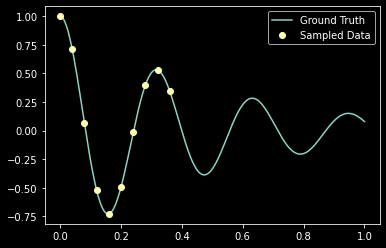

In [128]:
delta, omega = 2, 20
x = torch.linspace(0,1,500)
y = oscillator(delta, omega, x)


x_ground_truth = x[0:200:20]
y_ground_truth = y[0:200:20]

plt.plot(x, y)
plt.plot(x_ground_truth, y_ground_truth, 'o')
plt.legend(['Ground Truth', 'Sampled Data'])

In [122]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,1),
        )
        
    def forward(self, x):
        return self.model(x)

In [123]:
EPOCHS = 20000
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 1e-3

In [124]:
model = PINN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
MSE_LOSS = nn.MSELoss()

In [125]:
PDE_POINTS = 100

def PDE_loss():
    
    mu = 2*delta
    k = omega**2
    
    t = torch.linspace(0,1, PDE_POINTS, requires_grad=True).view(-1,1).to(DEVICE)
    x = model(t).view(-1,1)
    
    x_t = derivative(x,t)
    x_tt = derivative(x_t,t)
    
    differatial_output = x_tt+mu*x_t+k*x
    
    loss = torch.mean(torch.square(differatial_output))
    
    return loss

Epoch: 1000	Overall Loss: 0.08028440177440643	PDE Loss: 0.05102935180664063


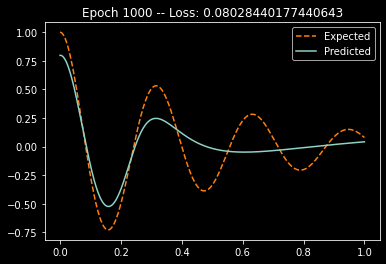

Epoch: 2000	Overall Loss: 0.024584418162703514	PDE Loss: 0.021955706787109376


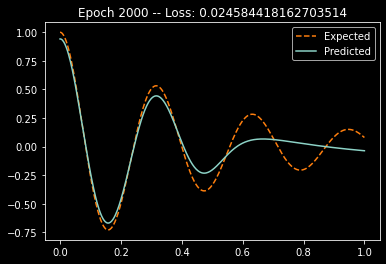

Epoch: 3000	Overall Loss: 0.01323691662400961	PDE Loss: 0.012331812286376954


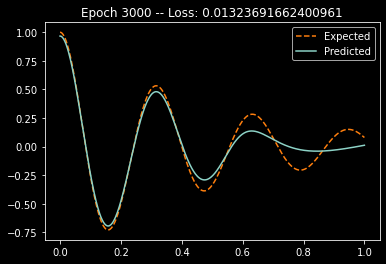

Epoch: 4000	Overall Loss: 0.01094089075922966	PDE Loss: 0.01042783203125


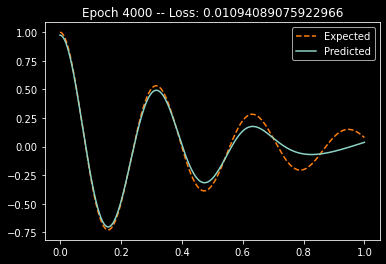

Epoch: 5000	Overall Loss: 0.017566993832588196	PDE Loss: 0.016891172790527344


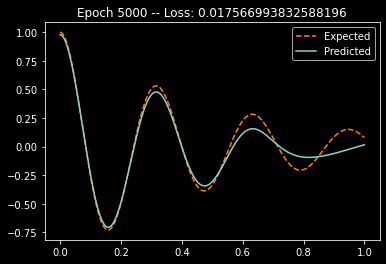

Epoch: 6000	Overall Loss: 0.009655269794166088	PDE Loss: 0.009260890197753906


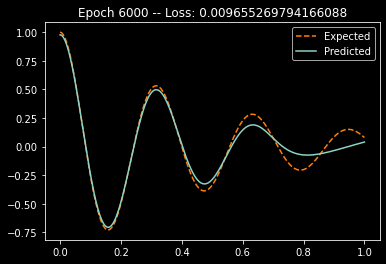

Epoch: 7000	Overall Loss: 0.010051338002085686	PDE Loss: 0.009631898498535157


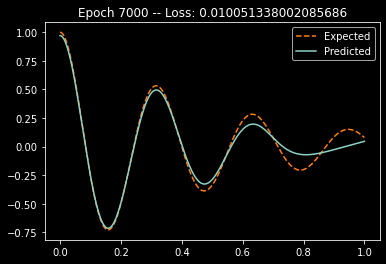

Epoch: 8000	Overall Loss: 0.009036330506205559	PDE Loss: 0.008693894195556641


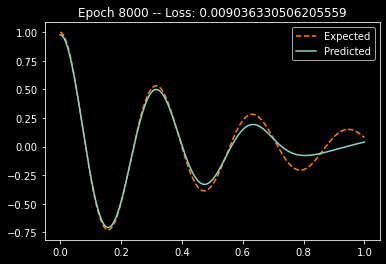

Epoch: 9000	Overall Loss: 0.008790059946477413	PDE Loss: 0.00845341262817383


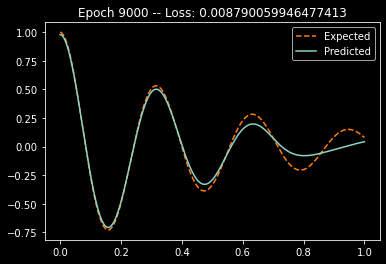

Epoch: 10000	Overall Loss: 0.010105261579155922	PDE Loss: 0.009694858551025391


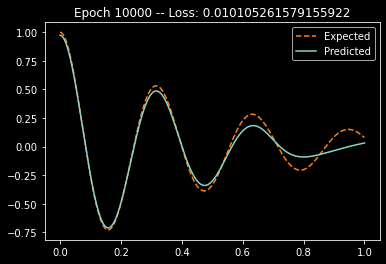

Epoch: 11000	Overall Loss: 0.008180871605873108	PDE Loss: 0.007890972137451172


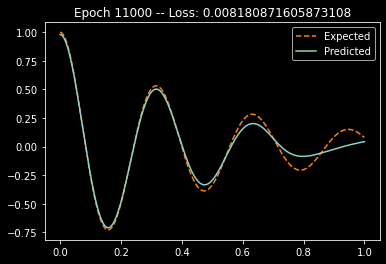

Epoch: 12000	Overall Loss: 0.007691619452089071	PDE Loss: 0.007427397155761719


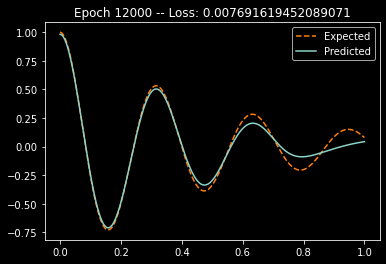

Epoch: 13000	Overall Loss: 0.006996368058025837	PDE Loss: 0.00676119613647461


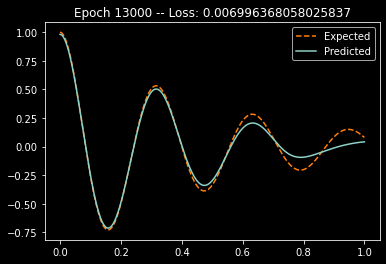

Epoch: 14000	Overall Loss: 0.005824915133416653	PDE Loss: 0.0056460205078125


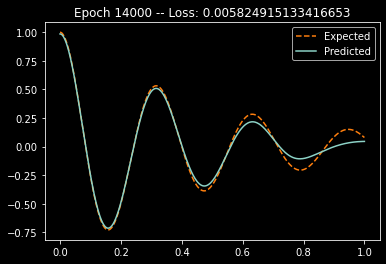

Epoch: 15000	Overall Loss: 0.004171757027506828	PDE Loss: 0.0040577625274658205


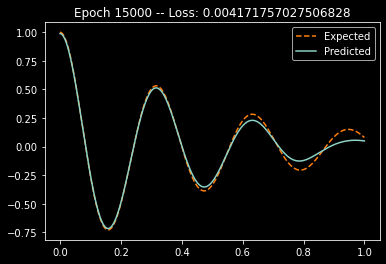

Epoch: 16000	Overall Loss: 0.0026147975586354733	PDE Loss: 0.002543505859375


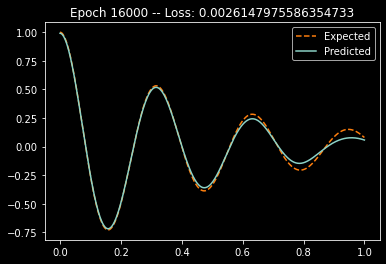

Epoch: 17000	Overall Loss: 0.0014127190224826336	PDE Loss: 0.0013856443405151368


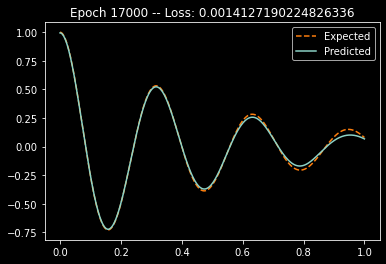

Epoch: 18000	Overall Loss: 0.0008221399039030075	PDE Loss: 0.0008117063522338867


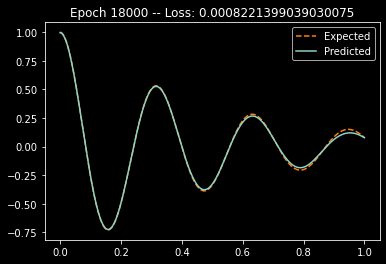

Epoch: 19000	Overall Loss: 0.0005955511587671936	PDE Loss: 0.0005897988319396972


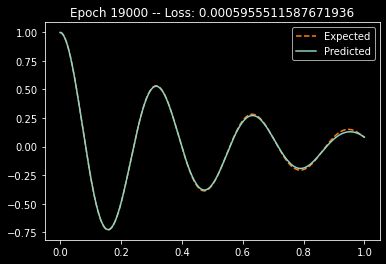

Epoch: 20000	Overall Loss: 0.00046858153655193746	PDE Loss: 0.0004653869152069092


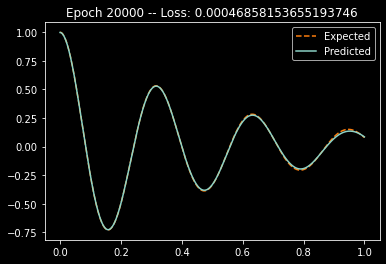

In [126]:
model.train()

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    
    pde_loss = PDE_loss()
    
    ground_truth_loss =  MSE_LOSS(model(x_ground_truth.to(DEVICE).view(-1,1)), y_ground_truth.to(DEVICE).view(-1,1))
    
    loss = (1e-4)*pde_loss + ground_truth_loss
    
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1000 == 0:
        
        
        print(f"Epoch: {epoch+1}\tOverall Loss: {loss.item()}\tPDE Loss: {(1e-4)*pde_loss.item()}")
        
        test_x = torch.linspace(0, 1, 500).reshape(-1, 1)
        
        position = model(test_x.to(DEVICE)).detach()
        plt.plot(x, y, color='tab:orange', linestyle='--') # from second cell
        plt.plot(test_x.view(-1), position.cpu().view(-1), label='theta')
        plt.title(f'Epoch {epoch+1} -- Loss: {loss.item()}')
        plt.legend(["Expected", "Predicted"])
        plt.show()